In [39]:
import numpy as np
import pandas as pd
import email
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from email.parser import BytesParser
from email.policy import default
import csv
import os
import pathlib
import pprint
from os.path import dirname, abspath


In [40]:
# d = dirname(dirname(abspath('__file__')))

In [41]:
#location = f"{d}/case study 3/"

In [42]:
# emails = {"index":[]}
# for path, subdirectories, filelist in os.walk(os.path.join(d,"SpamAssassinMessages")):
#     for f in filelist:
        
#         label = 0 if "ham" in path.lower() else 1
#         with open(os.path.join(path, f), "rb") as fp:
#             msg = BytesParser(policy=default).parse(fp)
#             with open(os.path.join(path, f), "r",encoding= 'utf-8', errors='ignore') as new_f:
#                 msg = email.message_from_file(new_f)
#                 for part in msg.walk():
#                     if part.get_content_type() == 'text/plain':
#                         body = part.get_payload()  # decode
#                 emails["index"].append({
#                     "Subject": msg.get("Subject"),
#                     "From": msg.get("from"),
#                     "Body": body,
#                     "isSpam": label,
#                     "FileID": f
#                 })

# df = pd.DataFrame.from_dict(emails["index"])

In [43]:
# df.to_csv("spam_train.csv", index=False)

In [44]:
df = pd.read_csv("spam_train.csv")

In [45]:
df["isSpam"].value_counts()

0    6954
1    2400
Name: isSpam, dtype: int64

In [46]:
df.isnull().sum()

Subject    26
From        7
Body        8
isSpam      0
FileID      0
dtype: int64

In [47]:
df = df.dropna()

In [48]:
df.reset_index(inplace=True, drop=True)

In [49]:
df.head(3)

,Subject,From,Body,isSpam,FileID
0,Let us find the right mortgage lender for you AFPE,pamela4701@eudoramail.com,"Dear Homeowner,\n \nInterest Rates are at their lowest point in 40 years!\n\nWe help you find the best rate for your situation by\nmatching your needs with hundreds of lenders!\n\nHome Improvement, Refinance, Second Mortgage,\nHome Equity Loans, and More! Even with less than\nperfect credit!\n\nThis service is 100% FREE to home owners and new\nhome buyers without any obligation. \n\nJust fill out a quick, simple form and jump-start\nyour future plans today!\n\n\nVisit http://61.145.116.186/user0201/index.asp?Afft=QM10\n\n\n\n\n\n\nTo unsubscribe, please visit:\n\nhttp://61.145.116.186/light/watch.asp\n\n\n",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,"Friend, Copy ANY DVD or Playstation Game with this software......",CopyYourDVD <atomica2020@hotmail.com>,"Friend,Now you can copy DVD's and Games\nhttp://www.terra.es/personal9/iop1008/\n\nBACKUP DVD VIDEO's WITH YOUR CD-R BURNER\n\nWith 321 studio's software, you can now copy\nany DVD and Playstation Game. Never buy another \nbackup DVD movie again. Just copy it!\n\nThis is the first time this software is being made\navailable to the public. All the software you need \nto burn your own DVD Video, is included in 321 Studio's \nsoftware package DVD Copy Plus! The movies will play \nin a standard DVD player. With detailed, easy to follow, \nstep-by-step instructions, you can BURN your own DVD \nVideo using nothing more than your DVD-ROM \nand CD-R drives. Purchase a copy! Click below.\n\nhttp://www.terra.es/personal9/iop1008/\n\nOrder today and receive!\n\n*Step by Step Interactive Instructions\n*All Software Tools Included On CD\n*No DVD Burner Required\n*FREE Live Technical Support\n*30 Day Risk Free Trial Available\n\nWith DVD Copy Plus you can backup Your DVD Movies with \nthe same 74min or 80min CD-R's you've used in the past \nto create audio CD's. Our software compresses the large \nDVD files on your standard DVD to VCD, SVCD, and DivX \nmuch the same way the popular MP3 format compresses audio. \nOrder today and start burning\nhttp://www.terra.es/personal9/iop1008/\n\nThank You,\n\nCopymyDVD\n\n\nhttp://inglesa.net/unsub.php?client=atomicDOT\n\n\n\nWe take your privacy very seriously and it is our policy never to send\nunwanted email messages. This message has been sent to zzzz@example.com\nbecause you originally joined one of our member sites or you signed up\nwith a party that has contracted with atomicDOT. Please\nhttp://tilw.net/unsub.php?client=atomicDOT&msgid=17090200005\nto Unsubscribe (replying to this email WILL NOT unsubscribe you). \n\n\n\n\n\nTRCK:atomicDOT;mp*qhwqrwhlqf!frp;8;\n\n\n",1,0355.94ebf637e4bd3db8a81c8ce68ecf681d
2,5% Guaranteed for Eight Years,"""IQ - Safe Harbor"" <sh@insiq.us>","Pocket the newest 8 year annuity!\t Pocket the newest 8 year\nannuity!\t\n \t ...from Safe Harbor Financial\t\n \t5% Guaranteed for 8 Years (effective yield)\t \n \t8 Year Surrender Period\t \t Please fax back contracts with\na copy of your insurance\nlicense to 215-564-0155.\nClick Here to Contract <http://iiq.us/images/sh/0903/sh_mony_app.pdf> \t\n \tIssued to Age 90\t \n \tA Rated Company\t \n \tAlternative 10 Year Guaranteed Plan\t \n\nCall today for more information!\n \n- or -\n\nPlease fill out the form below for more information\t \nName:\t \t \t\nAddress:\t \t \nCity:\t State: Zip: \t\nPhone:\t Fax: \t\nE-mail:\t \t \n \t \t\n \n \nWe don't want anyone to receive our mailings who does not wish to\nreceive them. This is a professional communication sent to insurance\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\nthis message. Instead, go here: http://www.insuranceiq.com/optout\n<http://www.insuranceiq.com/optout/> \n\nLegal Notice <http://www.insiq.com/legal.htm> \n",1,0395.bb934e8b4c39d5eab38f828a26f760b4


In [50]:
df["isSpam"].value_counts()

0    6941
1    2379
Name: isSpam, dtype: int64

Build a spam classifier using naive Bayes and clustering. You will have to create your own dataset from the input messages. Be sure to document how you created your dataset.

In [51]:
#remove new lines and such
df = df.replace(r'\n',' ', regex=True)
df = df.replace(r'\t',' ', regex=True)
df = df.replace(r'b\'',' ', regex=True)
df = df.replace(r'b\"',' ', regex=True)


In [52]:
df.head(2)

,Subject,From,Body,isSpam,FileID
0,Let us find the right mortgage lender for you AFPE,pamela4701@eudoramail.com,"Dear Homeowner, Interest Rates are at their lowest point in 40 years! We help you find the best rate for your situation by matching your needs with hundreds of lenders! Home Improvement, Refinance, Second Mortgage, Home Equity Loans, and More! Even with less than perfect credit! This service is 100% FREE to home owners and new home buyers without any obligation. Just fill out a quick, simple form and jump-start your future plans today! Visit http://61.145.116.186/user0201/index.asp?Afft=QM10 To unsubscribe, please visit: http://61.145.116.186/light/watch.asp",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,"Friend, Copy ANY DVD or Playstation Game with this software......",CopyYourDVD <atomica2020@hotmail.com>,"Friend,Now you can copy DVD's and Games http://www.terra.es/personal9/iop1008/ BACKUP DVD VIDEO's WITH YOUR CD-R BURNER With 321 studio's software, you can now copy any DVD and Playstation Game. Never buy another backup DVD movie again. Just copy it! This is the first time this software is being made available to the public. All the software you need to burn your own DVD Video, is included in 321 Studio's software package DVD Copy Plus! The movies will play in a standard DVD player. With detailed, easy to follow, step-by-step instructions, you can BURN your own DVD Video using nothing more than your DVD-ROM and CD-R drives. Purchase a copy! Click below. http://www.terra.es/personal9/iop1008/ Order today and receive! *Step by Step Interactive Instructions *All Software Tools Included On CD *No DVD Burner Required *FREE Live Technical Support *30 Day Risk Free Trial Available With DVD Copy Plus you can backup Your DVD Movies with the same 74min or 80min CD-R's you've used in the past to create audio CD's. Our software compresses the large DVD files on your standard DVD to VCD, SVCD, and DivX much the same way the popular MP3 format compresses audio. Order today and start burning http://www.terra.es/personal9/iop1008/ Thank You, CopymyDVD http://inglesa.net/unsub.php?client=atomicDOT We take your privacy very seriously and it is our policy never to send unwanted email messages. This message has been sent to zzzz@example.com because you originally joined one of our member sites or you signed up with a party that has contracted with atomicDOT. Please http://tilw.net/unsub.php?client=atomicDOT&msgid=17090200005 to Unsubscribe (replying to this email WILL NOT unsubscribe you). TRCK:atomicDOT;mp*qhwqrwhlqf!frp;8;",1,0355.94ebf637e4bd3db8a81c8ce68ecf681d


In [53]:
pd.set_option('display.max_colwidth', None)

In [54]:
df = df.replace(r'<',' ', regex=True)
df = df.replace(r'>',' ', regex=True)

In [55]:
df["Body"] = df['Body'].str.lower()

In [56]:
df["Subject"] = df['Subject'].str.lower()

In [57]:
df["From"] = df['From'].str.lower()

In [58]:
X = df.drop(["isSpam","FileID"], axis=1).copy()

In [59]:
X.head()

,Subject,From,Body
0,let us find the right mortgage lender for you afpe,pamela4701@eudoramail.com,"dear homeowner, interest rates are at their lowest point in 40 years! we help you find the best rate for your situation by matching your needs with hundreds of lenders! home improvement, refinance, second mortgage, home equity loans, and more! even with less than perfect credit! this service is 100% free to home owners and new home buyers without any obligation. just fill out a quick, simple form and jump-start your future plans today! visit http://61.145.116.186/user0201/index.asp?afft=qm10 to unsubscribe, please visit: http://61.145.116.186/light/watch.asp"
1,"friend, copy any dvd or playstation game with this software......",copyyourdvd atomica2020@hotmail.com,"friend,now you can copy dvd's and games http://www.terra.es/personal9/iop1008/ backup dvd video's with your cd-r burner with 321 studio's software, you can now copy any dvd and playstation game. never buy another backup dvd movie again. just copy it! this is the first time this software is being made available to the public. all the software you need to burn your own dvd video, is included in 321 studio's software package dvd copy plus! the movies will play in a standard dvd player. with detailed, easy to follow, step-by-step instructions, you can burn your own dvd video using nothing more than your dvd-rom and cd-r drives. purchase a copy! click below. http://www.terra.es/personal9/iop1008/ order today and receive! *step by step interactive instructions *all software tools included on cd *no dvd burner required *free live technical support *30 day risk free trial available with dvd copy plus you can backup your dvd movies with the same 74min or 80min cd-r's you've used in the past to create audio cd's. our software compresses the large dvd files on your standard dvd to vcd, svcd, and divx much the same way the popular mp3 format compresses audio. order today and start burning http://www.terra.es/personal9/iop1008/ thank you, copymydvd http://inglesa.net/unsub.php?client=atomicdot we take your privacy very seriously and it is our policy never to send unwanted email messages. this message has been sent to zzzz@example.com because you originally joined one of our member sites or you signed up with a party that has contracted with atomicdot. please http://tilw.net/unsub.php?client=atomicdot&msgid=17090200005 to unsubscribe (replying to this email will not unsubscribe you). trck:atomicdot;mp*qhwqrwhlqf!frp;8;"
2,5% guaranteed for eight years,"""iq - safe harbor"" sh@insiq.us","pocket the newest 8 year annuity! pocket the newest 8 year annuity! ...from safe harbor financial 5% guaranteed for 8 years (effective yield) 8 year surrender period please fax back contracts with a copy of your insurance license to 215-564-0155. click here to contract http://iiq.us/images/sh/0903/sh_mony_app.pdf issued to age 90 a rated company alternative 10 year guaranteed plan call today for more information! - or - please fill out the form below for more information name: address: city: state: zip: phone: fax: e-mail: we don't want anyone to receive our mailings who does not wish to receive them. this is a professional communication sent to insurance professionals. to be removed from this mailing list, do not reply to this message. instead, go here: http://www.insuranceiq.com/optout http://www.insuranceiq.com/optout/ legal notice http://www.insiq.com/legal.htm"
3,congratulations! you get a free handheld organizer!,customer service greatoffers@sendgreatoffers.com,"pocket the newest 8 year annuity! pocket the newest 8 year annuity! ...from safe harbor financial 5% guaranteed for 8 years (effective yield) 8 year surrender period please fax back contracts with a copy of your insurance license to 215-564-0155. click here to contract http://iiq.us/images/sh/0903/sh_mony_app.pdf issued to age 90 a rated company alternative 10 year guaranteed plan call today for more information! - or - please fill out t

In [60]:
X["Email"] = X["Subject"] +" "+ X["From"] +" "+ X["Body"]

In [61]:
X.head(2)

,Subject,From,Body,Email
0,let us find the right mortgage lender for you afpe,pamela4701@eudoramail.com,"dear homeowner, interest rates are at their lowest point in 40 years! we help you find the best rate for your situation by matching your needs with hundreds of lenders! home improvement, refinance, second mortgage, home equity loans, and more! even with less than perfect credit! this service is 100% free to home owners and new home buyers without any obligation. just fill out a quick, simple form and jump-start your future plans today! visit http://61.145.116.186/user0201/index.asp?afft=qm10 to unsubscribe, please visit: http://61.145.116.186/light/watch.asp","let us find the right mortgage lender for you afpe pamela4701@eudoramail.com dear homeowner, interest rates are at their lowest point in 40 years! we help you find the best rate for your situation by matching your needs with hundreds of lenders! home improvement, refinance, second mortgage, home equity loans, and more! even with less than perfect credit! this service is 100% free to home owners and new home buyers without any obligation. just fill out a quick, simple form and jump-start your future plans today! visit http://61.145.116.186/user0201/index.asp?afft=qm10 to unsubscribe, please visit: http://61.145.116.186/light/watch.asp"
1,"friend, copy any dvd or playstation game with this software......",copyyourdvd atomica2020@hotmail.com,"friend,now you can copy dvd's and games http://www.terra.es/personal9/iop1008/ backup dvd video's with your cd-r burner with 321 studio's software, you can now copy any dvd and playstation game. never buy another backup dvd movie again. just copy it! this is the first time this software is being made available to the public. all the software you need to burn your own dvd video, is included in 321 studio's software package dvd copy plus! the movies will play in a standard dvd player. with detailed, easy to follow, step-by-step instructions, you can burn your own dvd video using nothing more than your dvd-rom and cd-r drives. purchase a copy! click below. http://www.terra.es/personal9/iop1008/ order today and receive! *step by step interactive instructions *all software tools included on cd *no dvd burner required *free live technical support *30 day risk free trial available with dvd copy plus you can backup your dvd movies with the same 74min or 80min cd-r's you've used in the past to create audio cd's. our software compresses the large dvd files on your standard dvd to vcd, svcd, and divx much the same way the popular mp3 format compresses audio. order today and start burning http://www.terra.es/personal9/iop1008/ thank you, copymydvd http://inglesa.net/unsub.php?client=atomicdot we take your privacy very seriously and it is our policy never to send unwanted email messages. this message has been sent to zzzz@example.com because you originally joined one of our member sites or you signed up with a party that has contracted with atomicdot. please http://tilw.net/unsub.php?client=atomicdot&msgid=17090200005 to unsubscribe (replying to this email will not unsubscribe you). trck:atomicdot;mp*qhwqrwhlqf!frp;8;","friend, copy any dvd or playstation game with this software...... copyyourdvd atomica2020@hotmail.com friend,now you can copy dvd's and games http://www.terra.es/personal9/iop1008/ backup dvd video's with your cd-r burner with 321 studio's software, you can now copy any dvd and playstation game. never buy another backup dvd movie again. just copy it! this is the first time this software is being made available to the public. all the software you need to burn your own dvd video, is included in 321 studio's software package dvd copy plus! the movies will play in a standard dvd player. with detailed, easy to follow, step-by-step instructions, you can burn your own dvd video using nothing more than your dvd-rom and cd-r drives. purchase a copy! click below. http://www.terra.es/personal9/iop1008/ order today and receive! *step by step

In [62]:
X = X.drop(columns=["Body","From","Subject"], axis=1)

In [63]:
X.reset_index(inplace=True,drop=True)

In [64]:
y = df["isSpam"].values
y

array([1, 1, 1, ..., 0, 0, 0])

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

c_vect = CountVectorizer(stop_words="english")
X = c_vect.fit_transform(X["Email"])

# tfidf = TfidfVectorizer()

In [66]:
X

<9320x70542 sparse matrix of type '<class 'numpy.int64'>'
	with 1105422 stored elements in Compressed Sparse Row format>

In [67]:
df_X = pd.DataFrame(X.todense(), columns = c_vect.get_feature_names_out())

In [68]:
X_dense = df_X.copy()

In [82]:
X_dbscan = df_X.copy()

# Baseline test for Naive Bayes with No Clustering

In [74]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics as mt
import time

skf = StratifiedKFold(random_state=42, n_splits=10,shuffle=True)
nb = MultinomialNB()

acc_scores = []

iter_num=0

for train_indices, test_indices in skf.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    nb.fit(X_train,y_train)  # train object

    y_hat = nb.predict(X_test) # get test set predictions
    print("====Iteration",iter_num," ====")
    acc = mt.accuracy_score(y_test,y_hat)
    acc_scores.append(acc)
    print('Accuracy:', acc)
    iter_num+=1
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")   
print('Mean Accuracy:', np.mean(acc_scores))

====Iteration 0  ====
Accuracy: 0.990343347639485
====Iteration 1  ====
Accuracy: 0.9914163090128756
====Iteration 2  ====
Accuracy: 0.9957081545064378
====Iteration 3  ====
Accuracy: 0.9935622317596566
====Iteration 4  ====
Accuracy: 0.9914163090128756
====Iteration 5  ====
Accuracy: 0.9935622317596566
====Iteration 6  ====
Accuracy: 0.990343347639485
====Iteration 7  ====
Accuracy: 0.9967811158798283
====Iteration 8  ====
Accuracy: 0.9881974248927039
====Iteration 9  ====
Accuracy: 0.9892703862660944
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Mean Accuracy: 0.9920600858369099
CPU times: user 82.3 ms, sys: 22.1 ms, total: 104 ms
Wall time: 105 ms


## Elbow Plot
We see that there are about two clusters using the elbow plot. So will append that to the dataframe for training and testing.

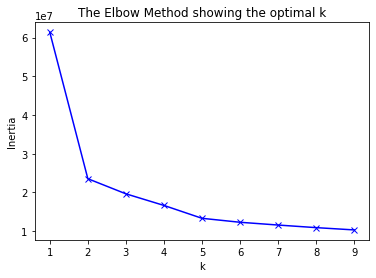

In [75]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# k means determine k
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    inertia.append(kmeanModel.inertia_)

# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [76]:
kmeans = KMeans(n_clusters=3).fit(X)
kmeans.fit(X)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [77]:
len(kmeans.labels_)

9320

In [78]:
X_dense["Kmeans_Three"] = kmeans.labels_

In [79]:
X_dense["Kmeans_Three"].value_counts()

0    9317
1       2
2       1
Name: Kmeans_Three, dtype: int64

# Added the Kmeans labels into a new column

In [80]:
from scipy.sparse import csr_matrix
new_X = csr_matrix(X_dense.values)
new_X

<9320x70543 sparse matrix of type '<class 'numpy.int64'>'
	with 1105425 stored elements in Compressed Sparse Row format>

In [81]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics as mt
import time

skf = StratifiedKFold(random_state=42, n_splits=10,shuffle=True)
nb = MultinomialNB()

acc_scores = []

iter_num=0

for train_indices, test_indices in skf.split(new_X,y): 
    X_train = new_X[train_indices]
    y_train = y[train_indices]
    
    X_test = new_X[test_indices]
    y_test = y[test_indices]
    nb.fit(X_train,y_train)  # train object

    y_hat = nb.predict(X_test) # get test set predictions
    print("====Iteration",iter_num," ====")
    acc = mt.accuracy_score(y_test,y_hat)
    acc_scores.append(acc)
    print('Accuracy:', acc)
    iter_num+=1
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")   
print('Mean Accuracy:', np.mean(acc_scores))

====Iteration 0  ====
Accuracy: 0.990343347639485
====Iteration 1  ====
Accuracy: 0.9914163090128756
====Iteration 2  ====
Accuracy: 0.9957081545064378
====Iteration 3  ====
Accuracy: 0.9935622317596566
====Iteration 4  ====
Accuracy: 0.9914163090128756
====Iteration 5  ====
Accuracy: 0.9935622317596566
====Iteration 6  ====
Accuracy: 0.990343347639485
====Iteration 7  ====
Accuracy: 0.9967811158798283
====Iteration 8  ====
Accuracy: 0.9881974248927039
====Iteration 9  ====
Accuracy: 0.9892703862660944
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Mean Accuracy: 0.9920600858369099
CPU times: user 83.5 ms, sys: 20.6 ms, total: 104 ms
Wall time: 103 ms


In [83]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscn = DBSCAN(eps=0.1, min_samples=5)
dbscn.fit(X_dbscan)
#newfeature_1 = cls1_dbscn.labels_ # the labels from kmeans clustering

# original_X = X_us.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)
# final_X = np.column_stack((original_X,pd.get_dummies(newfeature_1)))

# acc = cross_val_score(clf,final_X,y=y_us,cv=cv)
# params.append((eps,mpts,acc.mean()*100,acc.std()*100))

# print("For Eps", eps, "For min pts",mpts,"The average accuracy = ", acc.mean()*100, "+-", acc.std()*100)